In [1]:
import warnings;
warnings.simplefilter('ignore')

# Install and Import Dependencies

In [2]:
# !pip install pystan prophet  ## Run only if you don't have pystand and prophet installed.

In [3]:
import pandas as pd
from prophet import Prophet

# Data Preprocessing

In [4]:
# Read the data into a Pandas DataFrame
ecommerce_df = pd.read_csv('../Resources/Ecommerce_Data_Updated.csv')
print(f"{ecommerce_df.shape} is the number of the rows and columns in the dataset.")
ecommerce_df.head()

(9994, 18) is the number of the rows and columns in the dataset.


,Order Date,Ship Date,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Sales Per Unit,Original Unit Price,Lead Time
0,2022-11-07,2022-11-10,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136,130.9800,130.98,3 days
1,2022-11-07,2022-11-10,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820,243.9800,243.98,3 days
2,2022-06-11,2022-06-15,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714,7.3100,7.31,4 days
3,2021-10-09,2021-10-16,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310,191.5155,348.21,7 days
4,2021-10-09,2021-10-16,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164,11.1840,13.98,7 days


In [5]:
# Check the columns
print(f"{len(ecommerce_df.columns)} -> is the number of columns.")
ecommerce_df.columns

18 -> is the number of columns.


Index(['Order Date', 'Ship Date', 'Ship Mode', 'Segment', 'Country', 'City',
       'State', 'Postal Code', 'Region', 'Category', 'Sub-Category', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Sales Per Unit',
       'Original Unit Price', 'Lead Time'],
      dtype='object')

In [6]:
# Drop unwanted columns    
## Keeping only numerical columns so we can get the average per "Order Date"
### NOTE: "prophet" takes only two columns & one of the columns has to be a date.
ecommerce_df = ecommerce_df.drop(columns = ["Ship Date", "Ship Mode", "Segment",
                                            "Country", "City", "State", "Postal Code", 
                                            "Sales Per Unit", "Lead Time",
                                            "Category", "Sub-Category",
                                            "Quantity", "Discount", "Original Unit Price",
                                            "Region"])  

print(ecommerce_df.shape)
# print the DataFrame in descending order - starting from the most recent date.
ecommerce_df.sort_values(by = "Order Date", ascending = False).head() 

(9994, 3)


,Order Date,Sales,Profit
906,2023-12-29,323.136,12.1176
907,2023-12-29,90.930,2.7279
1296,2023-12-29,13.904,4.5188
1297,2023-12-29,20.720,6.4750
645,2023-12-29,209.300,56.5110


In [7]:
## Group by the "Order Date" Then take the average of the "Sales" Column
ecommerce_df = ecommerce_df.groupby("Order Date")
ecommerce_df_mean = ecommerce_df.mean().reset_index()

print(ecommerce_df_mean.shape)
# print the DataFrame in ascending order - starting from the oldest date.
ecommerce_df_mean.sort_values(by = "Order Date", ascending = True).head() 

(1237, 3)


,Order Date,Sales,Profit
0,2020-01-02,16.448000,5.551200
1,2020-01-03,96.020000,-21.996700
2,2020-01-04,19.536000,4.884000
3,2020-01-05,489.677778,150.894711
4,2020-01-06,43.579000,-35.981050


### Predicting the `Sales` 

In [8]:
# Keep only the "Order Date" and the "Sales" columns 
ecommerce_df_mean.drop(["Profit"], axis=1, inplace=True)

# Rename the "Sales" column to "y"
# and "Order Date" to "ds"
ecommerce_df_mean.columns = ['ds', 'y']  

print(f"{ecommerce_df_mean.shape} is the number of rows and columns that will be used in our forecast.")
ecommerce_df_mean.head()                    

(1237, 2) is the number of rows and columns that will be used in our forecast.


,ds,y
0,2020-01-02,16.448000
1,2020-01-03,96.020000
2,2020-01-04,19.536000
3,2020-01-05,489.677778
4,2020-01-06,43.579000


In [9]:
## Just for curiosity
print(ecommerce_df_mean["ds"].min())
print(ecommerce_df_mean["ds"].max())

2020-01-02
2023-12-29


# Train The Model

In [10]:
# NOTE: interval_width is the width of the uncertainty intervals provided for the forecast.
m = Prophet(interval_width=0.95, daily_seasonality=True) 
model = m.fit(ecommerce_df_mean)

21:05:52 - cmdstanpy - INFO - Chain [1] start processing
21:05:52 - cmdstanpy - INFO - Chain [1] done processing


# `Sales` Forecasting

In [11]:
# Forecasting the "Sales" for the coming 365 days from the last recorded data that we have.
future = m.make_future_dataframe(periods=365, freq='D', include_history = False)  
forecast = m.predict(future)

## Just for curiosity
print(forecast["ds"].min())
print(f'{forecast["ds"].max()} \n')
print(forecast.shape)

forecast.head()

2023-12-30 00:00:00
2024-12-28 00:00:00 

(365, 22)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-12-30,93.445769,-351.352252,732.854455,93.445769,93.445769,105.828158,105.828158,105.828158,138.597816,...,-16.284166,-16.284166,-16.284166,-16.485492,-16.485492,-16.485492,0.0,0.0,0.0,199.273927
1,2023-12-31,93.443045,-300.421963,770.218072,93.443045,93.443045,121.551688,121.551688,121.551688,138.597816,...,1.438898,1.438898,1.438898,-18.485025,-18.485025,-18.485025,0.0,0.0,0.0,214.994733
2,2024-01-01,93.440320,-285.678605,728.952633,93.439325,93.440320,127.079746,127.079746,127.079746,138.597816,...,8.242386,8.242386,8.242386,-19.760456,-19.760456,-19.760456,0.0,0.0,0.0,220.520066
3,2024-01-02,93.437596,-360.008531,744.231784,93.434151,93.438645,139.214416,139.214416,139.214416,138.597816,...,20.820785,20.820785,20.820785,-20.204185,-20.204185,-20.204185,0.0,0.0,0.0,232.652012
4,2024-01-03,93.434872,-335.905766,709.298264,93.428490,93.437553,94.908125,94.908125,94.908125,138.597816,...,-23.963403,-23.963403,-23.963403,-19.726287,-19.726287,-19.726287,0.0,0.0,0.0,188.342997


Text(74.22222222222221, 0.5, 'Sales')

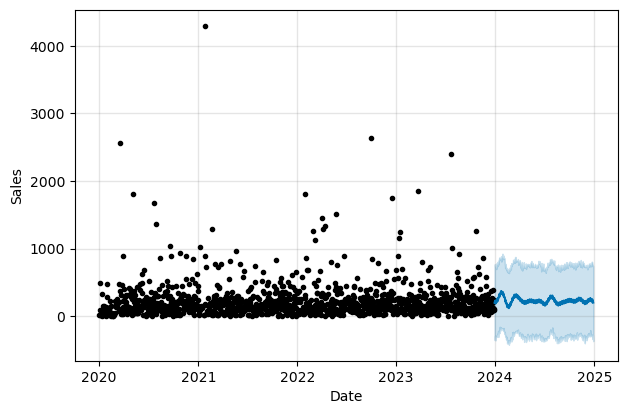

In [12]:
plot1 = m.plot(forecast)

# Resize the plot
plot1.set_size_inches(6,4)

# gca --> "get the current axis" and set it to the desired name.
plot1.gca().set_xlabel("Date")
plot1.gca().set_ylabel("Sales")

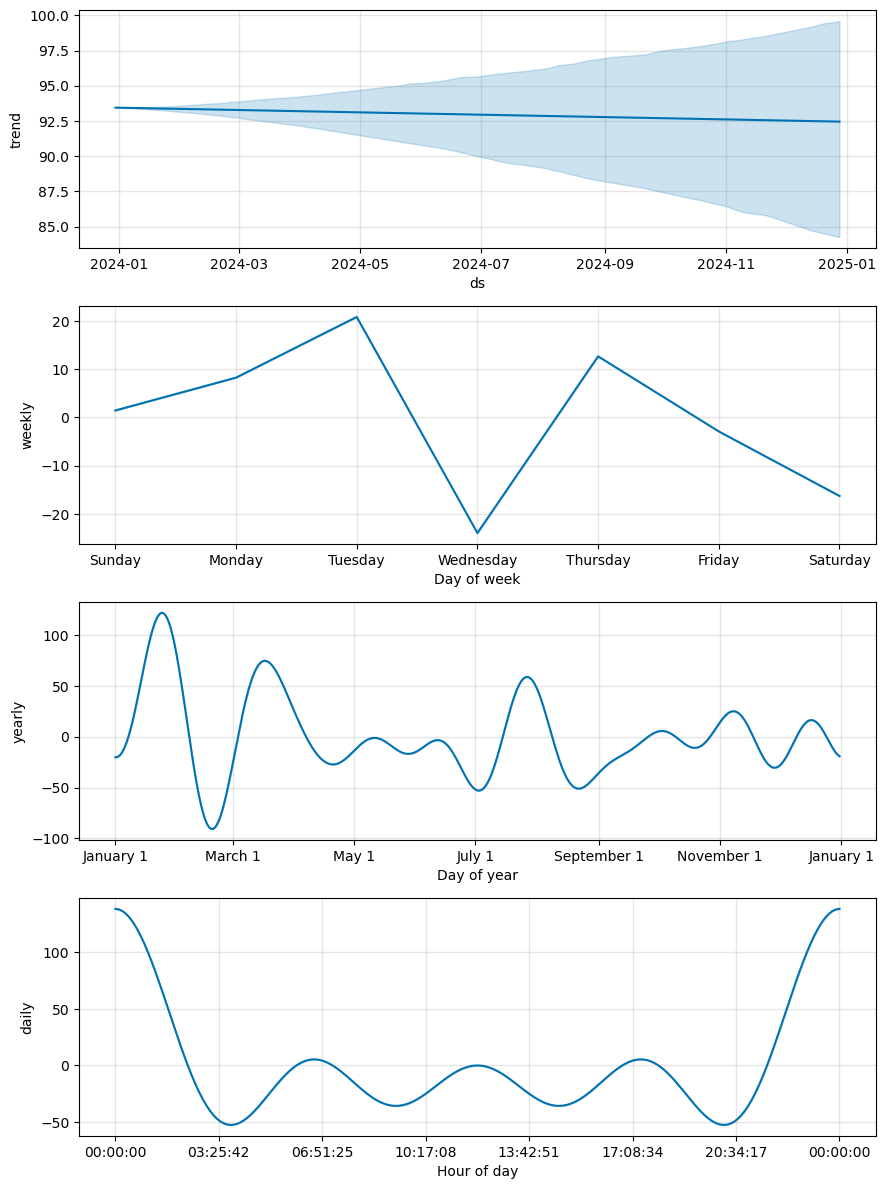

In [13]:
plt2 = m.plot_components(forecast)